# **WiDS Datathon 2025 - Unraveling the Mysteries of the Female Brain: Sex Patterns in ADHD**
## **Authors:** Sergiu Buhatel and Ramy El Gharbawy

## **Import the necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import seaborn as sns

# To scale the data using z-score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Algorithms to use
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Metrics to evaluate the model
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,recall_score,precision_score, accuracy_score

# For tuning the model
from sklearn.model_selection import GridSearchCV
from IPython.display import display, HTML

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

## **Data Overview**

- Reading the dataset
- Understanding the shape of the dataset
- Checking the data types
- Checking for missing values

In [2]:
# Loading the datasets
df_train_categorical = pd.read_excel('./Data/TRAIN/TRAIN_CATEGORICAL_METADATA.xlsx').set_index("participant_id")
df_train_functional = pd.read_csv('./Data/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv').set_index("participant_id")
df_train_quantitative = pd.read_excel('./Data/TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx').set_index("participant_id")
df_training_solutions = pd.read_excel('./Data/TRAIN/TRAINING_SOLUTIONS.xlsx').set_index("participant_id")

df_test_categorical = pd.read_excel('./Data/TEST/TEST_CATEGORICAL.xlsx').set_index("participant_id")
#df_test_functional = pd.read_csv('./Data/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv').set_index("participant_id")
df_test_quantitative = pd.read_excel('./Data/TEST/TEST_QUANTITATIVE_METADATA.xlsx').set_index("participant_id")

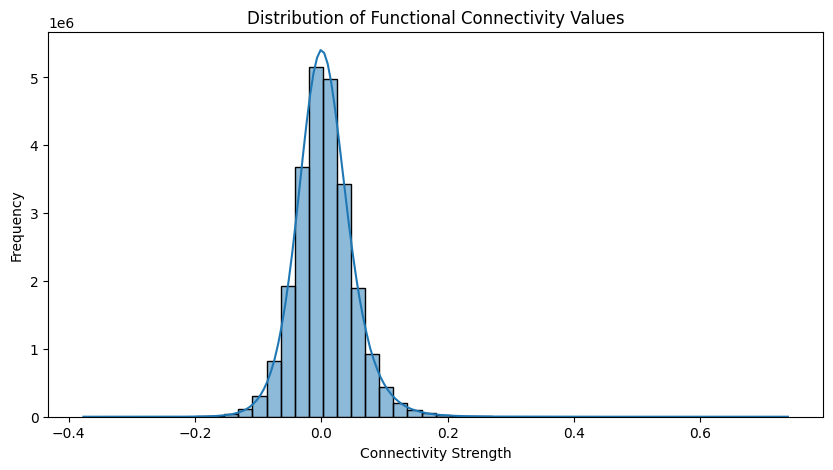

In [3]:
# PLotting a histogram of the functional connectivity values
plt.figure(figsize=(10, 5))
sns.histplot(df_train_functional.values.flatten(), bins=50, kde=True)
plt.xlabel("Connectivity Strength")
plt.ylabel("Frequency")
plt.title("Distribution of Functional Connectivity Values")
plt.show()

Is the matrix symmetric? True


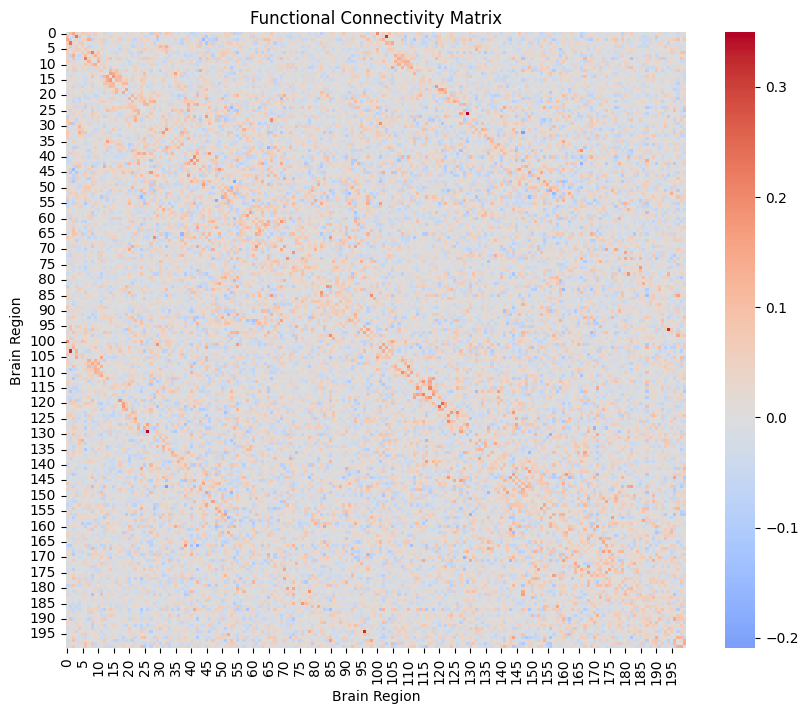

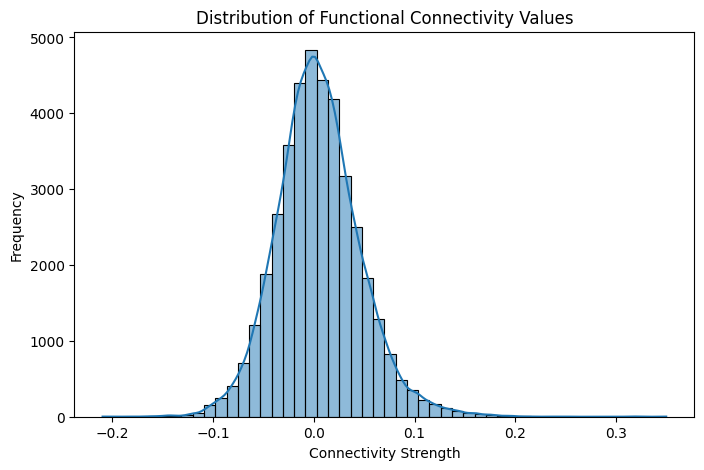

In [4]:
values = df_train_functional.iloc[0, :].values

if values.shape[0] == 19900:  # Likely an upper-triangle representation
    n = 200  # Assuming 200 regions
    matrix = np.zeros((n, n))  # Create empty symmetric matrix

    # Get upper triangle indices
    triu_indices = np.triu_indices(n, k=1)

    # Fill the upper triangle
    matrix[triu_indices] = values

    # Mirror to make it symmetric
    matrix = matrix + matrix.T

#  Check symmetry
print("Is the matrix symmetric?", np.allclose(matrix, matrix.T, atol=1e-5))

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, cmap="coolwarm", center=0)
plt.title("Functional Connectivity Matrix")
plt.xlabel("Brain Region")
plt.ylabel("Brain Region")
plt.show()

# Plot histogram of values
plt.figure(figsize=(8, 5))
sns.histplot(matrix.flatten(), bins=50, kde=True)
plt.title("Distribution of Functional Connectivity Values")
plt.xlabel("Connectivity Strength")
plt.ylabel("Frequency")
plt.show()

In [5]:
# Copying data to another variable to avoid any changes to original data
data_train_categorical=df_train_categorical.copy()
#data_train_functional=df_train_functional.copy()
data_train_quantitative=df_train_quantitative.copy()
data_training_solutions=df_training_solutions.copy()

data_test_categorical=df_test_categorical.copy()
#data_test_functional=df_test_functional.copy()
data_test_quantitative=df_test_quantitative.copy()

In [6]:
def display_head_with_scroll(data):
    # Convert the DataFrame to HTML and wrap it with a div that enables horizontal scrolling
    html = data.head().to_html()
    html_with_scroll = f'<div style="overflow-x: auto; white-space: nowrap;">{html}</div>'
    
    # Display the HTML with the scroll
    display(HTML(html_with_scroll))

# Check for null values
def columns_containing_null(df):
    # Get the count of null values per column
    null_count = df.isnull().sum()
    
    # Filter to show only columns with null values
    columns_with_nulls = null_count[null_count > 0]
    
    print("\nColumns containing null and how many values are null:\n" + str(columns_with_nulls) + "\n")

def summary_statistics(data):
    # Creating numerical columns
    num_cols = data.select_dtypes('number').columns
    
    # Checking the descriptive statistics of the numerical columns
    html = data[num_cols].describe().T.to_html()

    html_with_scroll = f'<div style="overflow-x: auto; white-space: nowrap;">{html}</div>'
    
    # Display the HTML with the scroll
    display(HTML(html_with_scroll))
    
def display_data(data, title = None):
    if title is not None:
        # Display the title as an h1 header
        display(HTML(f'<h3>{title}</h1>'))
        
    display_head_with_scroll(data)

    # Get shape of the dataset in terms of number of rows and number of colums
    print("Shape:" + str(data.shape) + "\n")
    
    # Check the data types as part of the info of the data
    data_train_categorical.info() 

    # Check for null values
    columns_containing_null(data)

    # Summary statistics
    summary_statistics(data)

# Function to get participant IDs with rows that have null values
def get_participant_ids_with_nulls(df):
    # Identify rows with any null value
    rows_with_nulls = df[df.isnull().any(axis=1)]
    
    # Get the participant_id (index) of those rows
    participant_ids_with_nulls = rows_with_nulls.index.tolist()
    
    return participant_ids_with_nulls
    
def display_shape_and_null_data(data, title = None):
    if title is not None:
        # Display the title as an h1 header
        display(HTML(f'<h3>{title}</h1>'))

    # Get shape of the dataset in terms of number of rows and number of colums
    print("Shape:" + str(data.shape) + "\n")

    # Check for null values
    participant_ids_with_nulls = get_participant_ids_with_nulls(data)
    print("Number of columns with null value:" + str(len(participant_ids_with_nulls)))

In [7]:
display_data(data_train_categorical, "TRAIN_CATEGORICAL_METADATA.xlsx")

,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
participant_id,,,,,,,,,
UmrK0vMLopoR,2016,1,0.0,0,1,21,45,21,45
CPaeQkhcjg7d,2019,3,1.0,2,3,15,15,0,0
Nb4EetVPm3gs,2016,1,1.0,8,1,18,40,0,0
p4vPhVu91o4b,2018,3,0.0,8,3,15,30,18,0
M09PXs7arQ5E,2019,3,0.0,1,3,15,20,0,0


Shape:(1213, 9)

<class 'pandas.core.frame.DataFrame'>
Index: 1213 entries, UmrK0vMLopoR to k8HhHnnu2wmt
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Basic_Demos_Enroll_Year           1213 non-null   int64  
 1   Basic_Demos_Study_Site            1213 non-null   int64  
 2   PreInt_Demos_Fam_Child_Ethnicity  1202 non-null   float64
 3   PreInt_Demos_Fam_Child_Race       1213 non-null   int64  
 4   MRI_Track_Scan_Location           1213 non-null   int64  
 5   Barratt_Barratt_P1_Edu            1213 non-null   int64  
 6   Barratt_Barratt_P1_Occ            1213 non-null   int64  
 7   Barratt_Barratt_P2_Edu            1213 non-null   int64  
 8   Barratt_Barratt_P2_Occ            1213 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 94.8+ KB

Columns containing null and how many values are null:
PreInt_Demos_Fam_Child_Ethnicity    11
dtype: int64



,count,mean,std,min,25%,50%,75%,max
Basic_Demos_Enroll_Year,1213.0,2017.652102,1.122522,2015.0,2017.0,2018.0,2019.0,2020.0
Basic_Demos_Study_Site,1213.0,2.014839,1.135147,1.0,1.0,1.0,3.0,4.0
PreInt_Demos_Fam_Child_Ethnicity,1202.0,0.424293,0.687470,0.0,0.0,0.0,1.0,3.0
PreInt_Demos_Fam_Child_Race,1213.0,2.080791,3.164636,0.0,0.0,0.0,2.0,11.0
MRI_Track_Scan_Location,1213.0,2.288541,0.758348,0.0,2.0,2.0,3.0,4.0
Barratt_Barratt_P1_Edu,1213.0,17.641385,4.004639,0.0,15.0,18.0,21.0,21.0
Barratt_Barratt_P1_Occ,1213.0,24.892828,17.025899,0.0,0.0,30.0,40.0,45.0
Barratt_Barratt_P2_Edu,1213.0,14.122012,7.201023,0.0,12.0,18.0,21.0,21.0
Barratt_Barratt_P2_Occ,1213.0,24.719703,17.171113,0.0,5.0,30.0,40.0,45.0


In [8]:
#display_data(data_train_functional, "TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv")

In [9]:
display_data(data_train_quantitative, "TRAIN_QUANTITATIVE_METADATA.xlsx")

,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
participant_id,,,,,,,,,,,,,,,,,,
UmrK0vMLopoR,40.00,13,3,10,47,13,11,28,0,6,1,5,0,5,1,0,10,NaN
CPaeQkhcjg7d,-94.47,14,3,13,34,18,23,30,0,18,6,8,7,8,10,4,5,NaN
Nb4EetVPm3gs,-46.67,14,4,10,35,16,10,29,1,14,2,8,5,7,6,4,9,8.239904
p4vPhVu91o4b,-26.68,10,5,12,39,19,16,28,6,24,4,16,9,10,8,4,6,NaN
M09PXs7arQ5E,0.00,14,5,15,40,20,24,28,1,18,4,11,4,10,7,3,9,8.940679


Shape:(1213, 18)

<class 'pandas.core.frame.DataFrame'>
Index: 1213 entries, UmrK0vMLopoR to k8HhHnnu2wmt
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Basic_Demos_Enroll_Year           1213 non-null   int64  
 1   Basic_Demos_Study_Site            1213 non-null   int64  
 2   PreInt_Demos_Fam_Child_Ethnicity  1202 non-null   float64
 3   PreInt_Demos_Fam_Child_Race       1213 non-null   int64  
 4   MRI_Track_Scan_Location           1213 non-null   int64  
 5   Barratt_Barratt_P1_Edu            1213 non-null   int64  
 6   Barratt_Barratt_P1_Occ            1213 non-null   int64  
 7   Barratt_Barratt_P2_Edu            1213 non-null   int64  
 8   Barratt_Barratt_P2_Occ            1213 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 94.8+ KB

Columns containing null and how many values are null:
MRI_Track_Age_at_Scan    360
dtype: int64



,count,mean,std,min,25%,50%,75%,max
EHQ_EHQ_Total,1213.0,58.876917,49.855501,-100.0,45.600000,76.670000,93.400000,100.000000
ColorVision_CV_Score,1213.0,13.164880,2.780624,0.0,14.000000,14.000000,14.000000,14.000000
APQ_P_APQ_P_CP,1213.0,3.781533,1.376700,0.0,3.000000,3.000000,4.000000,12.000000
APQ_P_APQ_P_ID,1213.0,13.205276,3.811772,0.0,11.000000,13.000000,16.000000,28.000000
APQ_P_APQ_P_INV,1213.0,39.374279,6.245928,0.0,36.000000,40.000000,43.000000,50.000000
APQ_P_APQ_P_OPD,1213.0,17.785655,3.764112,0.0,16.000000,18.000000,20.000000,28.000000
APQ_P_APQ_P_PM,1213.0,16.393240,5.376994,0.0,13.000000,16.000000,19.000000,37.000000
APQ_P_APQ_P_PP,1213.0,25.246496,3.950529,0.0,23.000000,26.000000,28.000000,30.000000
SDQ_SDQ_Conduct_Problems,1213.0,2.059357,2.023322,0.0,0.000000,2.000000,3.000000,10.000000
SDQ_SDQ_Difficulties_Total,1213.0,12.122836,6.577207,0.0,7.000000,12.000000,17.000000,34.000000


In [10]:
display_data(data_training_solutions, "TRAINING_SOLUTIONS.xlsx")

,ADHD_Outcome,Sex_F
participant_id,,
UmrK0vMLopoR,1,1
CPaeQkhcjg7d,1,0
Nb4EetVPm3gs,1,0
p4vPhVu91o4b,1,1
M09PXs7arQ5E,1,1


Shape:(1213, 2)

<class 'pandas.core.frame.DataFrame'>
Index: 1213 entries, UmrK0vMLopoR to k8HhHnnu2wmt
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Basic_Demos_Enroll_Year           1213 non-null   int64  
 1   Basic_Demos_Study_Site            1213 non-null   int64  
 2   PreInt_Demos_Fam_Child_Ethnicity  1202 non-null   float64
 3   PreInt_Demos_Fam_Child_Race       1213 non-null   int64  
 4   MRI_Track_Scan_Location           1213 non-null   int64  
 5   Barratt_Barratt_P1_Edu            1213 non-null   int64  
 6   Barratt_Barratt_P1_Occ            1213 non-null   int64  
 7   Barratt_Barratt_P2_Edu            1213 non-null   int64  
 8   Barratt_Barratt_P2_Occ            1213 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 94.8+ KB

Columns containing null and how many values are null:
Series([], dtype: int64)



,count,mean,std,min,25%,50%,75%,max
ADHD_Outcome,1213.0,0.685078,0.464676,0.0,0.0,1.0,1.0,1.0
Sex_F,1213.0,0.342951,0.474891,0.0,0.0,0.0,1.0,1.0


In [11]:
display_data(data_test_categorical, "TEST_CATEGORICAL.xlsx")

,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
participant_id,,,,,,,,,
Cfwaf5FX7jWK,2022,4,0.0,0.0,4,21.0,30.0,18.0,30.0
vhGrzmvA3Hjq,2023,4,0.0,0.0,4,21.0,45.0,NaN,30.0
ULliyEXjy4OV,2022,4,0.0,0.0,4,21.0,40.0,18.0,40.0
LZfeAb1xMtql,2022,4,0.0,0.0,3,21.0,45.0,21.0,45.0
EnFOUv0YK1RG,2022,4,2.0,0.0,4,18.0,0.0,21.0,45.0


Shape:(304, 9)

<class 'pandas.core.frame.DataFrame'>
Index: 1213 entries, UmrK0vMLopoR to k8HhHnnu2wmt
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Basic_Demos_Enroll_Year           1213 non-null   int64  
 1   Basic_Demos_Study_Site            1213 non-null   int64  
 2   PreInt_Demos_Fam_Child_Ethnicity  1202 non-null   float64
 3   PreInt_Demos_Fam_Child_Race       1213 non-null   int64  
 4   MRI_Track_Scan_Location           1213 non-null   int64  
 5   Barratt_Barratt_P1_Edu            1213 non-null   int64  
 6   Barratt_Barratt_P1_Occ            1213 non-null   int64  
 7   Barratt_Barratt_P2_Edu            1213 non-null   int64  
 8   Barratt_Barratt_P2_Occ            1213 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 94.8+ KB

Columns containing null and how many values are null:
PreInt_Demos_Fam_Child_Ethnicity     3
PreInt_Demos_Fam_Child_Ra

,count,mean,std,min,25%,50%,75%,max
Basic_Demos_Enroll_Year,304.0,2022.197368,0.494718,2019.0,2022.0,2022.0,2022.0,2023.0
Basic_Demos_Study_Site,304.0,4.009868,0.099012,4.0,4.0,4.0,4.0,5.0
PreInt_Demos_Fam_Child_Ethnicity,301.0,0.355482,0.665741,0.0,0.0,0.0,1.0,3.0
PreInt_Demos_Fam_Child_Race,298.0,2.231544,3.392914,0.0,0.0,0.0,3.0,11.0
MRI_Track_Scan_Location,304.0,3.638158,0.481326,3.0,3.0,4.0,4.0,4.0
Barratt_Barratt_P1_Edu,303.0,19.128713,2.680553,3.0,18.0,21.0,21.0,21.0
Barratt_Barratt_P1_Occ,303.0,29.389439,16.484193,0.0,25.0,35.0,45.0,45.0
Barratt_Barratt_P2_Edu,268.0,18.458955,3.087093,3.0,18.0,18.0,21.0,21.0
Barratt_Barratt_P2_Occ,262.0,35.763359,11.978162,0.0,30.0,40.0,45.0,45.0


In [12]:
#display_data(data_test_functional, "TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")

In [13]:
display_data(data_test_quantitative, "TEST_QUANTITATIVE_METADATA.xlsx")

,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
participant_id,,,,,,,,,,,,,,,,,,
Cfwaf5FX7jWK,60.03,14.0,5.0,16.0,41.0,19.0,11.0,26.0,2.0,12.0,3.0,9.0,2.0,7.0,3.0,0.0,8.0,8.992813
vhGrzmvA3Hjq,86.71,12.0,3.0,13.0,43.0,18.0,15.0,28.0,2.0,16.0,8.0,5.0,7.0,3.0,11.0,3.0,9.0,12.324093
ULliyEXjy4OV,26.68,13.0,3.0,14.0,36.0,16.0,14.0,25.0,1.0,7.0,1.0,6.0,1.0,5.0,1.0,0.0,9.0,7.770933
LZfeAb1xMtql,93.38,13.0,3.0,19.0,41.0,17.0,18.0,27.0,4.0,15.0,4.0,10.0,8.0,6.0,5.0,1.0,6.0,9.304814
EnFOUv0YK1RG,-93.38,14.0,3.0,13.0,42.0,19.0,16.0,28.0,2.0,18.0,6.0,12.0,5.0,10.0,6.0,0.0,10.0,8.261350


Shape:(304, 18)

<class 'pandas.core.frame.DataFrame'>
Index: 1213 entries, UmrK0vMLopoR to k8HhHnnu2wmt
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Basic_Demos_Enroll_Year           1213 non-null   int64  
 1   Basic_Demos_Study_Site            1213 non-null   int64  
 2   PreInt_Demos_Fam_Child_Ethnicity  1202 non-null   float64
 3   PreInt_Demos_Fam_Child_Race       1213 non-null   int64  
 4   MRI_Track_Scan_Location           1213 non-null   int64  
 5   Barratt_Barratt_P1_Edu            1213 non-null   int64  
 6   Barratt_Barratt_P1_Occ            1213 non-null   int64  
 7   Barratt_Barratt_P2_Edu            1213 non-null   int64  
 8   Barratt_Barratt_P2_Occ            1213 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 94.8+ KB

Columns containing null and how many values are null:
EHQ_EHQ_Total                  1
ColorVision_CV_Score          

,count,mean,std,min,25%,50%,75%,max
EHQ_EHQ_Total,303.0,59.144488,49.330962,-100.050000,50.060000,73.370000,93.380000,100.050000
ColorVision_CV_Score,295.0,13.240678,1.986273,0.000000,13.000000,14.000000,14.000000,14.000000
APQ_P_APQ_P_CP,289.0,3.321799,0.810248,2.000000,3.000000,3.000000,3.000000,8.000000
APQ_P_APQ_P_ID,289.0,13.259516,3.627411,6.000000,11.000000,13.000000,16.000000,23.000000
APQ_P_APQ_P_INV,289.0,39.633218,5.153586,20.000000,36.000000,40.000000,43.000000,50.000000
APQ_P_APQ_P_OPD,289.0,16.726644,3.360000,7.000000,14.000000,17.000000,19.000000,27.000000
APQ_P_APQ_P_PM,289.0,15.944637,4.931163,9.000000,12.000000,15.000000,19.000000,31.000000
APQ_P_APQ_P_PP,289.0,24.826990,3.283666,10.000000,23.000000,25.000000,28.000000,30.000000
SDQ_SDQ_Conduct_Problems,274.0,1.890511,1.973000,0.000000,0.000000,1.000000,3.000000,10.000000
SDQ_SDQ_Difficulties_Total,274.0,11.781022,6.056771,0.000000,7.000000,11.000000,16.000000,29.000000


In [14]:
# Check the data types as part of the info of the data
data_train_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1213 entries, UmrK0vMLopoR to k8HhHnnu2wmt
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Basic_Demos_Enroll_Year           1213 non-null   int64  
 1   Basic_Demos_Study_Site            1213 non-null   int64  
 2   PreInt_Demos_Fam_Child_Ethnicity  1202 non-null   float64
 3   PreInt_Demos_Fam_Child_Race       1213 non-null   int64  
 4   MRI_Track_Scan_Location           1213 non-null   int64  
 5   Barratt_Barratt_P1_Edu            1213 non-null   int64  
 6   Barratt_Barratt_P1_Occ            1213 non-null   int64  
 7   Barratt_Barratt_P2_Edu            1213 non-null   int64  
 8   Barratt_Barratt_P2_Occ            1213 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 94.8+ KB


In [15]:
# Get three lists of participant_id that have at least one column as null
participant_ids_with_null_categorical = get_participant_ids_with_nulls(data_train_categorical)
participant_ids_with_null_quantitative = get_participant_ids_with_nulls(data_train_quantitative)
participant_ids_with_null_solutions = get_participant_ids_with_nulls(data_training_solutions)

participant_ids_with_null_test_categorical = get_participant_ids_with_nulls(data_test_categorical)
participant_ids_with_null_test_quantitative = get_participant_ids_with_nulls(data_test_quantitative)

# Aggregate the lists into one list excluding duplicates
aggregate_participant_ids_with_null = list(set(participant_ids_with_null_categorical) | 
                                           set(participant_ids_with_null_quantitative) | 
                                           set(participant_ids_with_null_solutions) |
                                           set(participant_ids_with_null_test_categorical)|
                                           set(participant_ids_with_null_test_quantitative))

## **Data Preprocessing**

### **Remove null items**
Remove items from all dataframes coresponding to any participant_id that has at least one column as null

In [16]:
# Remove items from dataframe coresponding to participant_id that have at least one column as null
def remove_items_based_on_participant_id_list(participant_id_list, df):
    # Remove rows where 'participant_id' (index) is in the list
    filtered_df = df[~df.index.isin(participant_id_list)]
    
    # Remove rows where any other column (except 'participant_id') is null
    filtered_df = filtered_df.dropna()
    
    return filtered_df

data_train_categorical = remove_items_based_on_participant_id_list(aggregate_participant_ids_with_null, data_train_categorical)
display_shape_and_null_data(data_train_categorical, "TRAIN_CATEGORICAL_METADATA.xlsx")

Shape:(845, 9)

Number of columns with null value:0


In [17]:
data_train_quantitative = remove_items_based_on_participant_id_list(aggregate_participant_ids_with_null, data_train_quantitative)
display_shape_and_null_data(data_train_quantitative, "TRAIN_QUANTITATIVE_METADATA.xlsx")

Shape:(845, 18)

Number of columns with null value:0


In [18]:
data_training_solutions = remove_items_based_on_participant_id_list(aggregate_participant_ids_with_null, data_training_solutions)
display_shape_and_null_data(data_training_solutions, "TRAINING_SOLUTIONS.xlsx")

Shape:(845, 2)

Number of columns with null value:0


In [19]:
data_test_categorical = remove_items_based_on_participant_id_list(aggregate_participant_ids_with_null, data_test_categorical)
display_shape_and_null_data(data_test_categorical, "TEST_CATEGORICAL.xlsx")

Shape:(214, 9)

Number of columns with null value:0


In [20]:
data_test_quantitative = remove_items_based_on_participant_id_list(aggregate_participant_ids_with_null, data_test_quantitative)
display_shape_and_null_data(data_test_quantitative, "TEST_QUANTITATIVE_METADATA.xlsx")

Shape:(214, 18)

Number of columns with null value:0


### **Aggregate training data and unseen data**
- Aggregate training data into data, and aggregate test data into unseen data
- Define label data

In [21]:
data_combined = pd.merge(data_train_quantitative, data_train_categorical, left_index=True, right_index=True, how="left")
labels=data_training_solutions.copy()
unseen_data_combined = pd.merge(data_test_quantitative, data_test_categorical, left_index=True, right_index=True, how="left")

In [22]:
#display_data(data_combined, "DATA COMBINED")
data_combined.shape

(845, 27)

In [23]:
#display_data(unseen_data_combined.shape, "UNSEEN DATA COMBINED")
unseen_data_combined.shape

(214, 27)

In [24]:
labels.shape

(845, 2)

## **Data Exploration**

### **Numerical and Categorical Columns**

In [25]:
# Identify numerical and categorical columns
numerical_cols = data_combined.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = data_combined.select_dtypes(include=['object']).columns

print("Numerical Columns: ", numerical_cols)
print("Categorical Columns: ", categorical_cols)

Numerical Columns:  Index(['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
       'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
       'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
       'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan',
       'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ'],
      dtype='object')
Categorical Columns:  Index([], dtype='object')


### **Correlation Analysis**
For numerical features, it’s important to explore how they correlate with each other and with the target variables. This will help identify potentially strong predictors and check for multicollinearity.

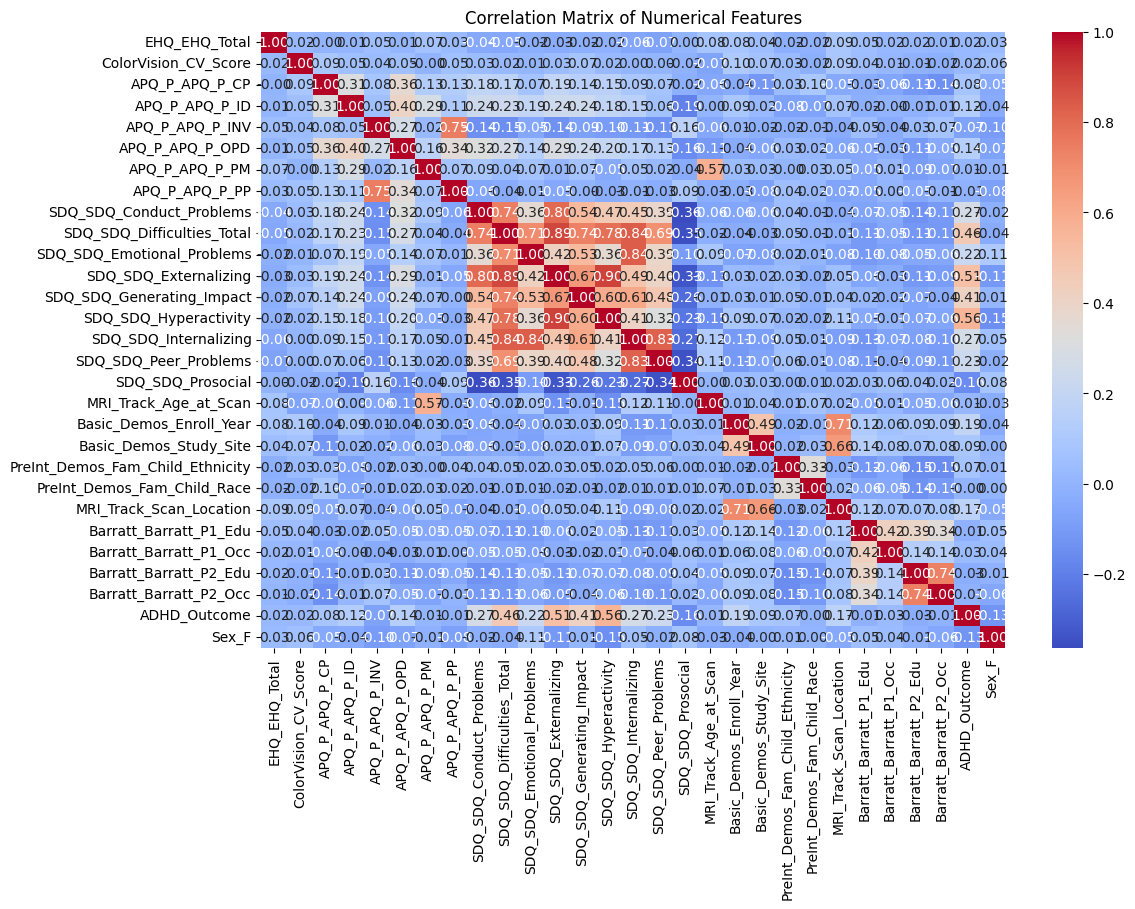

In [34]:
data_combined_with_labels = pd.merge(data_combined, labels, left_index=True, right_index=True, how="left")
numerical_cols = list(numerical_cols) + ["ADHD_Outcome", "Sex_F"]

# Correlation heatmap for numerical features
correlation_matrix = data_combined_with_labels[numerical_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Numerical Features")
plt.show()

### **Visualizing the Data**
Visualizing the relationship between features and target variables can provide deeper insights. Here are a few ideas for visualizations:

Boxplots/Histograms: To explore the distribution of numerical features.
Count Plots: For categorical variables, like Sex_F and ADHD_Outcome.

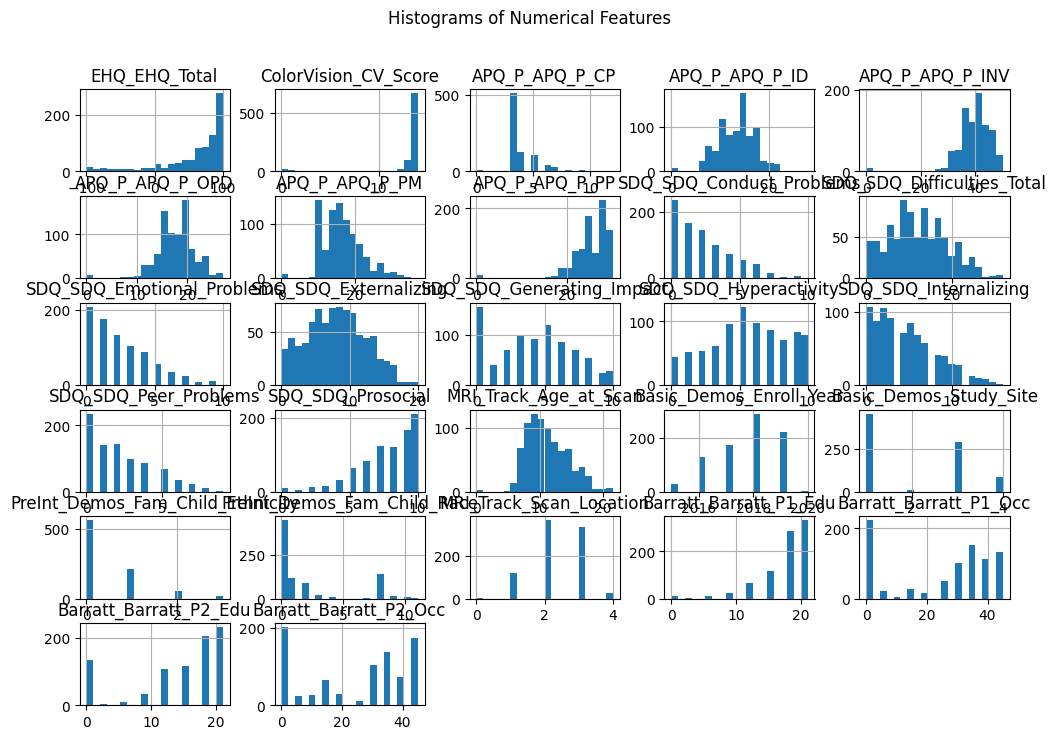

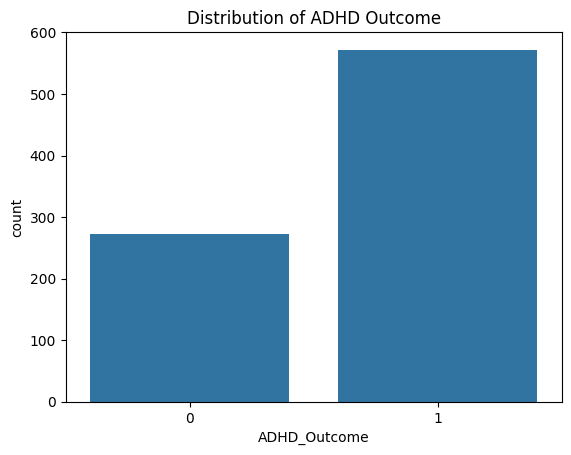

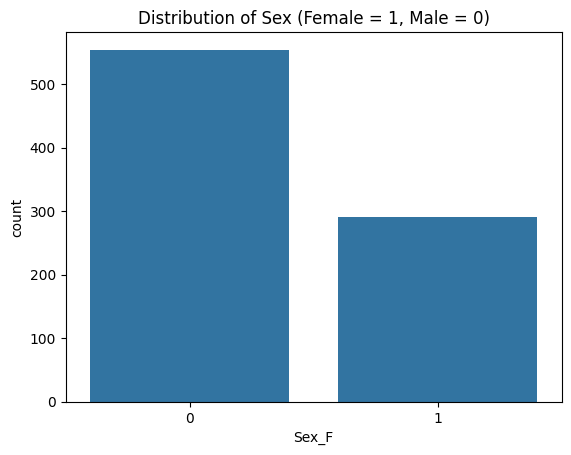

In [27]:
# Visualize the distribution of numerical features
data_combined[numerical_cols].hist(bins=20, figsize=(12, 8))
plt.suptitle("Histograms of Numerical Features")
plt.show()

# Visualize the distribution of ADHD_Outcome from the labels DataFrame
sns.countplot(x='ADHD_Outcome', data=labels)
plt.title('Distribution of ADHD Outcome')
plt.show()

# Visualize the distribution of Sex_F from the labels DataFrame
sns.countplot(x='Sex_F', data=labels)
plt.title('Distribution of Sex (Female = 1, Male = 0)')
plt.show()

## **Split data into training and testing**
- Split the data into 80% training and 20% testing, and stratify based on male or female ('Sex_F') from the labels variable. 
- Set a random_state, so that it will generate the same random output each time. This controls the seed for the random number generator.

In [28]:
# Renamed labels and data_combined into Y and X
Y = labels
X = data_combined

# Splitting the data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1, stratify = Y)

# Split labels into "ADHD_Outcome" and "Sex_F"
y_train_adhd = y_train["ADHD_Outcome"]
y_train_sex = y_train["Sex_F"]
y_test_adhd = y_test["ADHD_Outcome"]
y_test_sex = y_test["Sex_F"]

In [29]:
x_train.shape

(676, 27)

In [30]:
x_test.shape

(169, 27)

In [31]:
y_train.shape

(676, 2)

In [32]:
y_test.shape

(169, 2)